# Applying the Model

This notebook takes the model developed in `model_development.ipynb` and runs it on a larger dataset.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# This random subset of 10,000 samples
csv_file_path = '../../../Data/fresh_data_012121/ecotaxa_export_live_10000_100221.csv'
validated_csv_fp = '../../../Data/fresh_data_012121/ecotaxa_export_live_10000_100221.csv'

imagery_fp = "../../../Data/fresh_data_012121/live/all_imagery/" # this imagery should all be in the same directory

In [3]:
model_save_fp = '../model_weights_230221_1.hdf5'
output_scaler_fp = 'scaler_feats_230221_1.gz'

In [4]:
img_md_subset = pd.read_csv(csv_file_path)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (264) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Identical to the model_development notebook we're dropping a subset of classes

In [5]:
# drop unwanted classes

# Here are groups we can cut:
classes_to_drop = ['Banquisia belgicae',
'Dinophyceae',
'pennate<Bacillariophyta',
'Licmophora',
'Rhizosolenia',
'centric 4 temp',
'centric 6 temp',
't005',
't006',
't009',
't019',
't020',
'Warnowia',
'Unknowns',
#'multiple<other'
]

img_md_subset = img_md_subset.drop(img_md_subset[img_md_subset.object_annotation_category.isin(classes_to_drop)].index)
len(img_md_subset)

9517

In [6]:
# Here are groups we can combine:

img_md_subset[img_md_subset.object_annotation_category == 'Tintinnida'] = 'Ciliophora'
img_md_subset[img_md_subset.object_annotation_category == 'Odontella sp.'] = 'chain<centric'
img_md_subset[img_md_subset.object_annotation_category == 'Eucampia chain'] = 'chain<centric'
len(img_md_subset)

9517

This code ensures it doesn't use the GPU which I am doing so I can run model dev and predictions at the same time but isn't necessary in other cases

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Check if it is using a GPU

In [8]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

Only use data where we have both labels and imagery

In [9]:
import glob, os

fn_list = []

for file in glob.glob(imagery_fp+'*.png'):
    fn_list.append(file)
    
print(len(fn_list))

# this splits based on the assumption there aren't any slashes in the filename
fn_edit = [x.split('/')[-1][:-4] for x in fn_list]

available_subset = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(available_subset)

3038045


9517

Bring in the dict from model_development

In [10]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'bubble': 20,
 'centric': 21,
 'centric 1 temp': 22,
 'centric 2 temp': 23,
 'centric 3 temp': 24,
 'chain<centric': 25,
 'chain<pennate': 26,
 'detritus': 27,
 'dinoflagellate-i': 28,
 'dinoflagellate-ii': 29,
 'dinoflagellate-iii': 30,
 'pennate 1 temp': 31,
 'pennate 10 temp': 32,
 'pennate 11 temp': 33,
 'pennate 2 temp': 34,
 'pennate 7 temp': 35,
 't007': 36,
 't012': 37,
 't013': 38,
 'temp cylindrotheca': 39}


id_class_dict = dict((v,k) for k,v in class_id_dict.items())

Columns not for training, identical from model_development

In [11]:
cols_not_for_training = ['img_file_name',
'object_id',
'object_link',
'object_lat',
'object_lon',
'object_date',
'object_time',
'object_depth_min',
'object_depth_max',
'object_annotation_category',
'object_annotation_date',
'object_annotation_hierarchy',
'object_annotation_hierarchy.1',
'object_annotation_person_email',
'object_annotation_person_name',
'object_annotation_status',
'object_annotation_time',
'object_score',
'acq_id',
'acq_instrument',
'acq_resolution_pixels_per_micron',
'process_id',
'process_soft',
'process_soft_version',
'process_script',
'process_script_version',
'process_library',
'process_library_version',
'process_date',
'process_time',
'sample_id',
'sample_source',
'sample_flag',
'sample_cruise',
'sample_vessel',
'sample_reference',
'sample_station',
'sample_cast',
'sample_source_id', 
'sample_culture_species',
'sample_concentration',
'sample_dataportal_descriptor',                        
'object_roi_number',
'Unnamed: 0',
'index',
'merged_category',
'level_0',
'sample_experiment_state',
'sample_experiment_dilution', 
'sample_experiment_light_level',
'sample_experiment_nutrients',
'object_area_over_perimeter_squared',            
'object_area_over_perimeter',                       
'object_h90_over_hflip',                           
'object_h90_over_h180',                              
'object_hflip_over_h180',                         
'object_summed_convex_perimeter_over_perimeter',   
'object_rotated_bounding_box_solidity']

In [12]:
len(class_id_dict)

40

If you want to only predict on a certain fraction of the dataset you can do it here

In [13]:
prediction_subset = available_subset.sample(frac=1)

In [14]:
del available_subset

In [15]:
prediction_subset.head()

,object_id,object_lat,object_lon,object_date,object_time,object_link,object_depth_min,object_depth_max,object_annotation_status,object_annotation_person_name,...,process_soft,process_soft_version,process_script,process_script_version,process_library,process_library_version,process_date,process_time,acq_id,acq_instrument
6333,D20200108T041601_IFCB116_08727,-64.8871,-64.5584,20200108,41601,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185460__,NaN
6422,D20200108T050250_IFCB116_02049,-64.8871,-64.5584,20200108,50250,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185463__,NaN
9431,D20200112T174426_IFCB116_07366,-65.351,-66.4773,20200112,174426,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185492__,NaN
4453,D20200106T234709_IFCB116_06556,-64.8868,-64.5563,20200106,234709,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__184816__,NaN
9488,D20200112T191759_IFCB116_03159,-65.351,-66.4773,20200112,191759,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185500__,NaN


In [16]:
len(prediction_subset)

9517

### filter out images based on size

Currently filtering based on a major axis < 25 pixels

In [17]:
small_object_ids = []

for index, row in prediction_subset.iterrows():
    if row['object_major_axis_length'] < 25:
        small_object_ids.append(row['object_id'])
len(small_object_ids)

4955

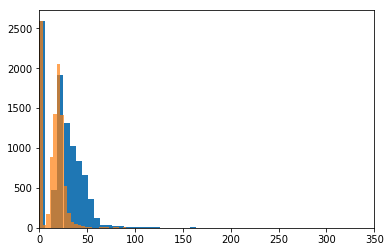

In [18]:
plt.hist(prediction_subset['object_major_axis_length'].values.astype(np.float16), bins=250)
plt.hist(prediction_subset['object_minor_axis_length'].values.astype(np.float16),alpha=0.7, bins=150)
plt.xlim(0,350)
plt.show()

In [19]:
small_df = prediction_subset[prediction_subset['object_id'].isin(small_object_ids)]

In [20]:
with pd.option_context('display.max_rows', 200):
    print(small_df.groupby('object_annotation_category')['object_id'].nunique())

object_annotation_category
Nitzschia frigida        1
Pyramimonas            133
badfocus<artefact     2139
bead                     3
detritus               586
multiple<other          61
pennate 1 temp          35
pennate 2 temp          44
t002                  1637
t007                     2
t012                   309
t013                     1
temp cylindrotheca       4
Name: object_id, dtype: int64


In [21]:
with pd.option_context('display.max_rows', 200):
    print(prediction_subset.groupby('object_annotation_category')['object_id'].nunique())

object_annotation_category
Amphiprora                     1
Chaetoceros<Mediophyceae       1
Ciliophora                     1
Cryptophyta                 1624
Cylindrotheca                  4
Eucampia                       1
Gymnodinium                   19
Gyrodinium                     1
Katodinium                     2
Navicula                       1
Nitzschia frigida             14
Pyramimonas                  423
badfocus<artefact           2211
bead                           3
bubble                        20
centric 1 temp                 5
centric 2 temp                53
centric 3 temp                 7
chain<centric                  2
chain<pennate                  8
detritus                    1119
dinoflagellate-i              28
dinoflagellate-ii             83
multiple<other               929
part<other                     5
pennate 1 temp               111
pennate 10 temp                2
pennate 11 temp               46
pennate 2 temp               303
pennate 7 temp  

badfocus<artefact


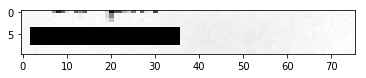

badfocus<artefact


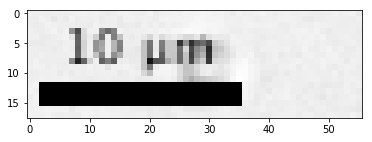

detritus


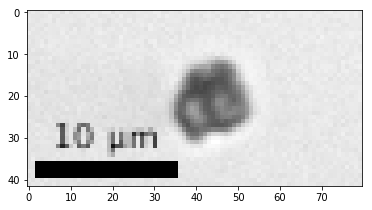

badfocus<artefact


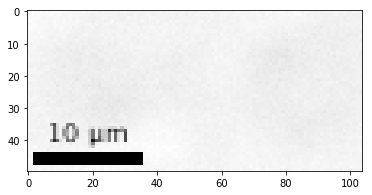

badfocus<artefact


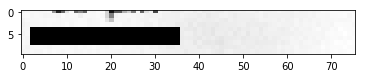

t002


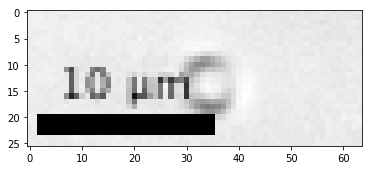

badfocus<artefact


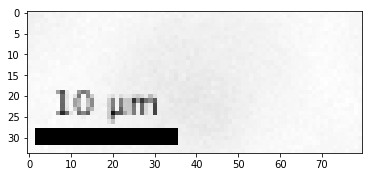

pennate 1 temp


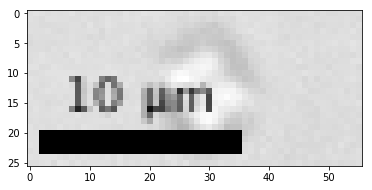

badfocus<artefact


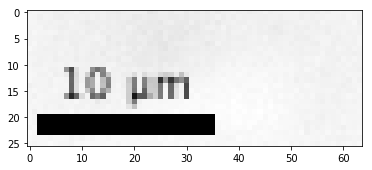

badfocus<artefact


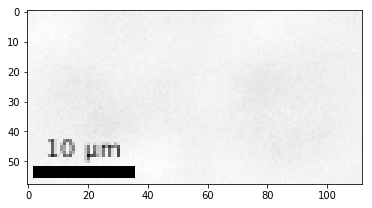

t002


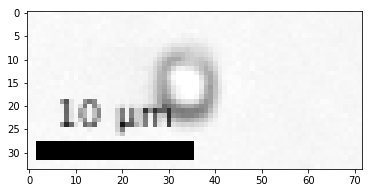

badfocus<artefact


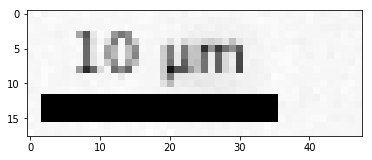

pennate 1 temp


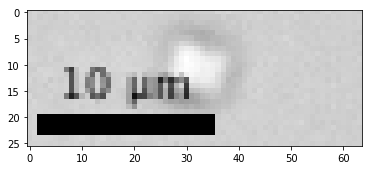

t012


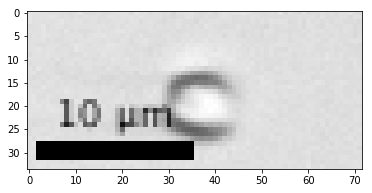

badfocus<artefact


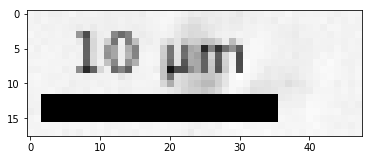

t012


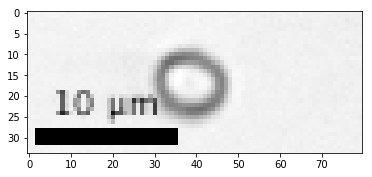

t002


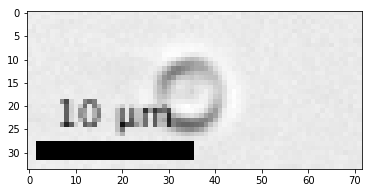

badfocus<artefact


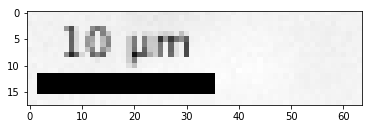

badfocus<artefact


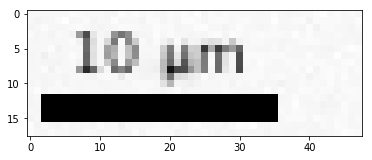

detritus


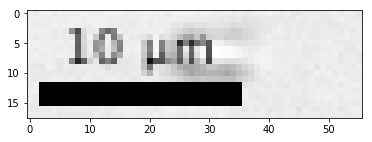

t002


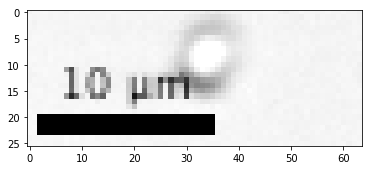

badfocus<artefact


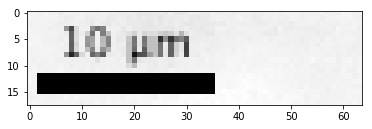

t002


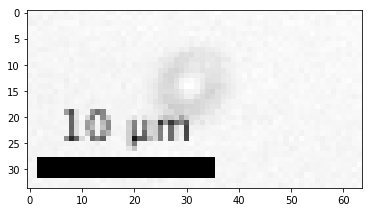

badfocus<artefact


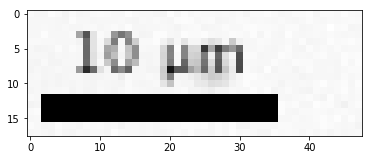

t012


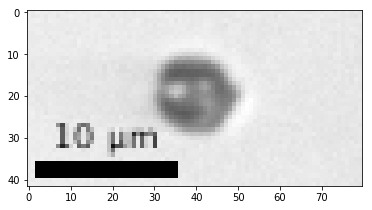

t002


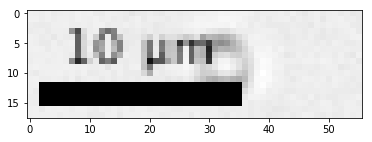

t002


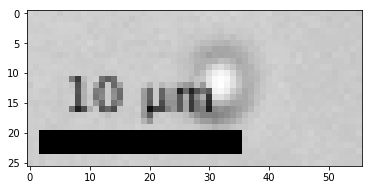

t002


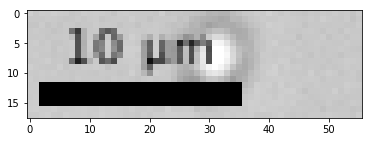

t002


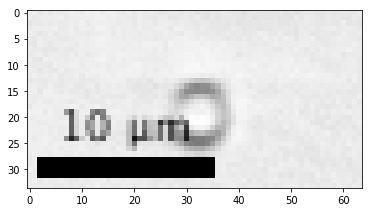

detritus


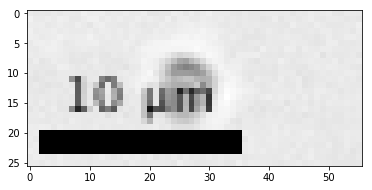

t002


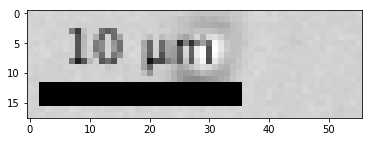

badfocus<artefact


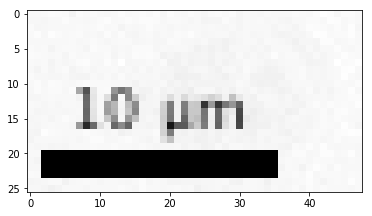

badfocus<artefact


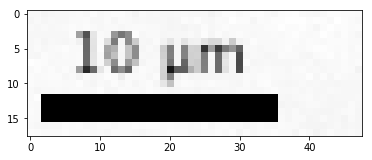

detritus


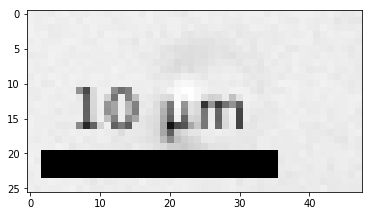

detritus


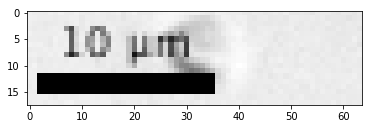

t002


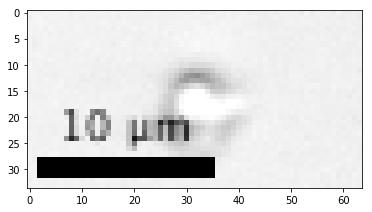

t002


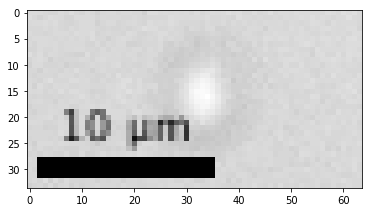

badfocus<artefact


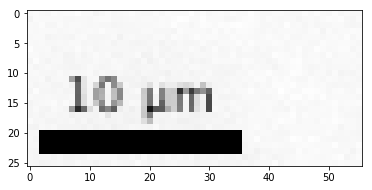

badfocus<artefact


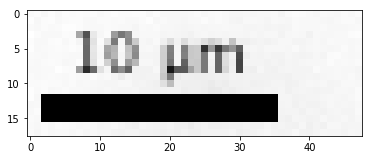

detritus


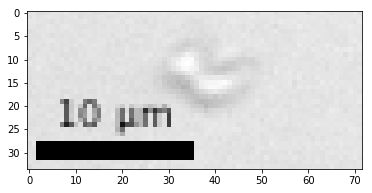

In [22]:
import cv2
for index, row in small_df.sample(n=40).iterrows():
    print(row['object_annotation_category'])
    im = cv2.imread(imagery_fp+row['object_id']+'.png', cv2.IMREAD_GRAYSCALE)
    plt.imshow(im, cmap="Greys_r")
    plt.show()

#### cut out the small cells

In [23]:
prediction_subset = prediction_subset[~prediction_subset['object_id'].isin(small_object_ids)]
len(prediction_subset)

4562

### Load in the model and the scaler for scaling features

In [24]:
from tensorflow import keras

model = keras.models.load_model(model_save_fp)

In [25]:
import joblib
from sklearn.preprocessing import StandardScaler

scaler = joblib.load(output_scaler_fp)

### The real generator

This data generator streams data so that an arbitrarily large dataset can be ingested and predicted

In [26]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

def generate_data(available_subset, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    while True:
        images = []
        labels = []
        merged_labels = []
        original_labels = []
        flu_data = []
        
        for b in range(batch_size):
            if i >= len(available_subset):
                i=0
            row = available_subset.iloc[i]
            i+=1
            
#             img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
#             images.append(image.img_to_array(img))
            desired_size = 150
            im = cv2.imread(imagery_fp+row['object_id']+'.png', cv2.IMREAD_GRAYSCALE)
            old_size = im.shape[:2] # old_size is in (height, width) format
            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            # new_size should be in (width, height) format
            im = cv2.resize(im, (new_size[1], new_size[0]))
            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            new_im = cv2.copyMakeBorder(im, 0, delta_h, 0, delta_w, cv2.BORDER_CONSTANT,0)
            img = new_im[..., np.newaxis]
            images.append(img)
    
            #labels.append(class_id_dict[row['merged_category']])
            #merged_labels.append(row['merged_category'])
            #original_labels.append(row['object_annotation_category'])
            flu_data.append(np.array(row[~available_subset.columns.isin(cols_not_for_training)].values, dtype=np.float32))
        
        # normalize
        image_batch = np.array(images) / 255
        flu_batch = np.array(flu_data)
        #flu_batch[np.isnan(flu_batch)] = 0
        flu_batch = scaler.transform(flu_batch)
        
        
        yield [image_batch, flu_batch]
        #yield [image_batch]

In [27]:
predict_prob = model.predict_generator(generator = generate_data(prediction_subset,batch_size=1), steps=len(prediction_subset)/1, verbose=1)

4562/4562 [==============================] - 65s 14ms/step


In [28]:
predictions = np.argmax(predict_prob, axis=1)

In [29]:
predict_prob_values = []
for i in range(len(predictions)):
    predict_prob_values.append(predict_prob[i][predictions[i]])

In [30]:
np.mean(predict_prob_values), np.std(predict_prob_values)

(0.8860058, 0.16957629)

(array([  30.,   60.,  100.,  189.,  188.,  225.,  224.,  232.,  386.,
        2928.]),
 array([0.27415505, 0.34673953, 0.41932404, 0.49190855, 0.56449306,
        0.6370775 , 0.709662  , 0.78224653, 0.854831  , 0.9274155 ,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

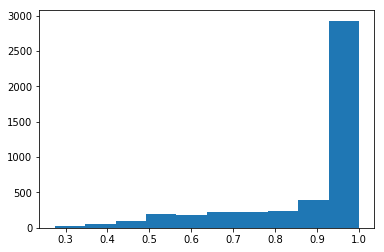

In [31]:
plt.hist(predict_prob_values)

In [32]:
prediction_subset['image_file_name'] = prediction_subset['object_id'] + '.png'

In [33]:
len(predictions), len(prediction_subset)

(4562, 4562)

In [34]:
prediction_subset['object_annotation_category'] = [id_class_dict[x] for x in predictions]

In [35]:
prediction_subset['object_score'] = predict_prob_values

In [36]:
prediction_subset['object_annotation_status'] = 'Predicted'

In [37]:
prediction_subset = prediction_subset[['object_id','object_annotation_status','object_annotation_category','sample_flag','object_lat','object_lon','image_file_name','object_score']]

In [38]:
len(prediction_subset)

4562

In [39]:
prediction_subset.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
9431,D20200112T174426_IFCB116_07366,Predicted,temp cylindrotheca,good,-65.351,-66.4773,D20200112T174426_IFCB116_07366.png,0.992653
4453,D20200106T234709_IFCB116_06556,Predicted,t012,good,-64.8868,-64.5563,D20200106T234709_IFCB116_06556.png,0.634618
9488,D20200112T191759_IFCB116_03159,Predicted,Pyramimonas,good,-65.351,-66.4773,D20200112T191759_IFCB116_03159.png,0.557428
296,D20171220T203215_IFCB116_11741,Predicted,Pyramimonas,good,-64.7535,-64.1339,D20171220T203215_IFCB116_11741.png,0.999910
6348,D20200108T041601_IFCB116_12427,Predicted,Dactyliosolen,good,-64.8871,-64.5584,D20200108T041601_IFCB116_12427.png,0.764125


In [40]:
classes, counts = np.unique(predictions, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 15, 16, 17, 18, 19,
        20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38,
        39]),
 array([  19,   24,    5,    6,    1, 1298,   12,   54,    1,   16,    2,
          35,  181,    2,    1,    7,  659,   73,    2,   39,   90,    6,
           2,  241,   98,   67,    2,  307,   12,   16,  398,   49,  607,
          51,  179]))

uncomment this to save

In [41]:
#prediction_subset.to_csv('live_predictions_10000_230221_1.csv', sep='\t')

### this grabs a random sample of these predictions and saves it

In [42]:
10000 / len(prediction_subset)

2.1920210434020166

In [43]:
len(prediction_subset.sample(frac=.0032916))

15

In [44]:
sample_prediction_subset = prediction_subset.sample(frac=.0032916)

uncomment this to save

In [45]:
#sample_prediction_subset.to_csv('../../live/ecotaxa_cnn_predictions_live_with_live_model_random_sample_070221.csv', sep='\t')

### compare the predictions to validated labels and evaluate

In [46]:
#live_preds = pd.read_csv('../ecotaxa_cnn_predictions_preserved_with_live_model_100_per_class_250121.csv', sep='\t')

# just set this equal if you've just predicted and it is still in memory
live_preds = prediction_subset
live_preds['validated_type'] = ''
live_preds.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score,validated_type
9431,D20200112T174426_IFCB116_07366,Predicted,temp cylindrotheca,good,-65.351,-66.4773,D20200112T174426_IFCB116_07366.png,0.992653,
4453,D20200106T234709_IFCB116_06556,Predicted,t012,good,-64.8868,-64.5563,D20200106T234709_IFCB116_06556.png,0.634618,
9488,D20200112T191759_IFCB116_03159,Predicted,Pyramimonas,good,-65.351,-66.4773,D20200112T191759_IFCB116_03159.png,0.557428,
296,D20171220T203215_IFCB116_11741,Predicted,Pyramimonas,good,-64.7535,-64.1339,D20171220T203215_IFCB116_11741.png,0.999910,
6348,D20200108T041601_IFCB116_12427,Predicted,Dactyliosolen,good,-64.8871,-64.5584,D20200108T041601_IFCB116_12427.png,0.764125,


Read in the file of validated data

In [47]:
live_val = pd.read_csv(validated_csv_fp)
live_val.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (264) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,object_id,object_lat,object_lon,object_date,object_time,object_link,object_depth_min,object_depth_max,object_annotation_status,object_annotation_person_name,...,process_soft,process_soft_version,process_script,process_script_version,process_library,process_library_version,process_date,process_time,acq_id,acq_instrument
0,D20171212T201207_IFCB116_00106,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
1,D20171212T201207_IFCB116_00378,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
2,D20171212T201207_IFCB116_00602,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
3,D20171212T201207_IFCB116_01090,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN
4,D20171212T201207_IFCB116_01165,-64.7356,-64.1037,20171212,201207,http://pal.lternet.edu/,0,0,validated,Schuyler Nardelli,...,MATLAB,R2019b,easyIFCB,a4aa03a38c9f40d1b8fd282ef7ede108607d2d82,ifcb-analysis,e9e37998a8bb8caf587b19418202b650ba0b99f2,YYYYMMDD,HHMMSS,__DUMMY_ID__185697__,NaN


Rename the `object_annotation_category` to `validated_type`

In [48]:
live_val = live_val[['object_id','object_annotation_category']]

live_val = live_val.rename(columns={'object_annotation_category': 'validated_type'})
live_val.head()

,object_id,validated_type
0,D20171212T201207_IFCB116_00106,Cryptophyta
1,D20171212T201207_IFCB116_00378,multiple<other
2,D20171212T201207_IFCB116_00602,t002
3,D20171212T201207_IFCB116_01090,Pyramimonas
4,D20171212T201207_IFCB116_01165,t002


#### update the prediction dataframe with validated labels

In [49]:
print(len(live_preds))
live_val = live_val.reset_index()
live_preds = live_preds.set_index('object_id')
live_val = live_val.set_index('object_id')
# this line updates it with the new column
live_preds.update(live_val[['validated_type']])

live_preds = live_preds.reset_index()
print(len(live_preds))

4562
4562


#### Look at how the multiple<other class was classified

In [50]:
with pd.option_context('display.max_rows', 200):
    print(live_preds[live_preds['validated_type'] == 'multiple<other'].groupby('object_annotation_category')['object_id'].nunique())

object_annotation_category
Amphiprora                   11
Chaetoceros single           18
Chaetoceros<Mediophyceae      3
Ciliophora                    2
Cryptophyta                   4
Dactyliosolen                48
Gymnodinium                   4
Nitzschia frigida            96
Phaeocystis                   2
Pyramimonas                 204
bubble                        1
centric 2 temp                2
centric 3 temp               56
chain<centric                 4
detritus                     99
dinoflagellate-i             11
dinoflagellate-ii             1
pennate 1 temp               65
pennate 2 temp               19
t012                        143
t013                         22
temp cylindrotheca           53
Name: object_id, dtype: int64


In [51]:
buckets = {}
for key in id_class_dict:
    buckets[key] = []

object_ids = []

max_count = 10

for index, row in live_preds[live_preds['validated_type'] == 'multiple<other'].iterrows():
    if len(buckets[class_id_dict[row['object_annotation_category']]]) < max_count:
        #object_ids.append(row['object_id'])
        buckets[class_id_dict[row['object_annotation_category']]].append(row['object_id'])

0

Look at 10 of each predicted class that was labeled as multiple

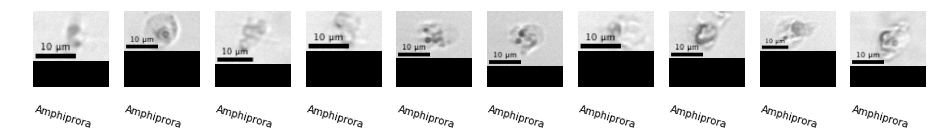

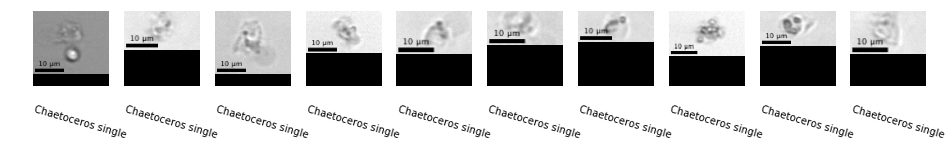

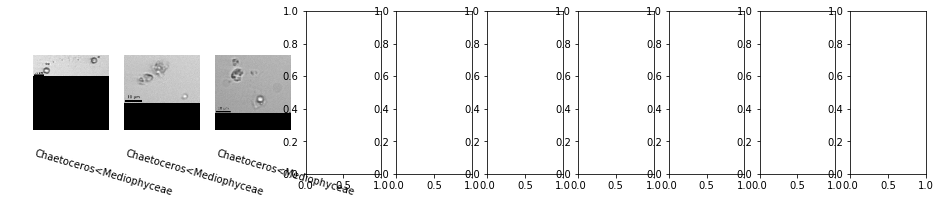

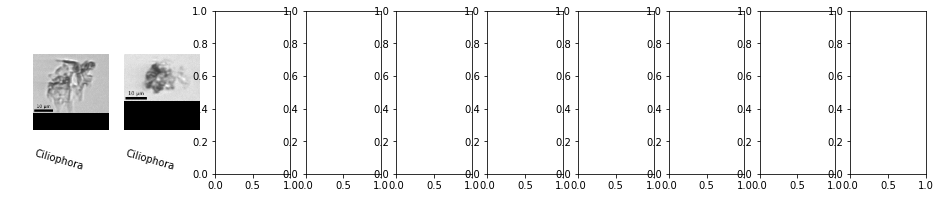

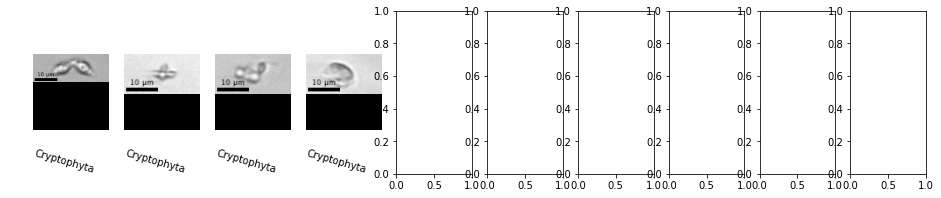

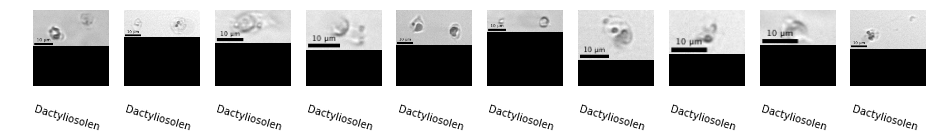

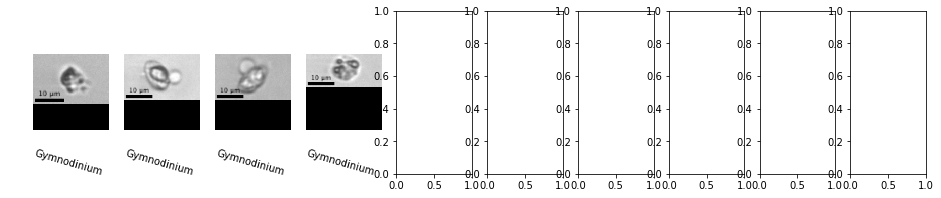

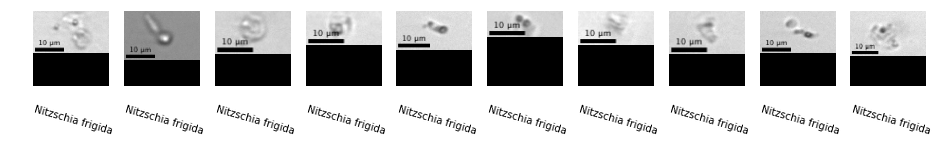

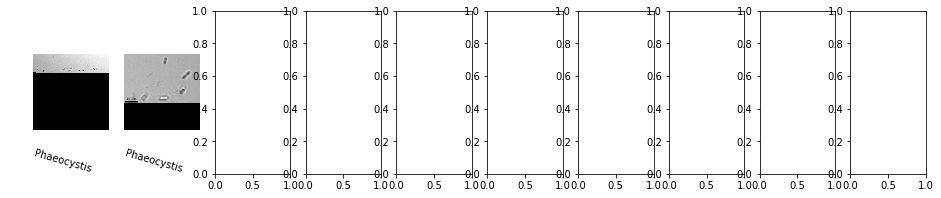

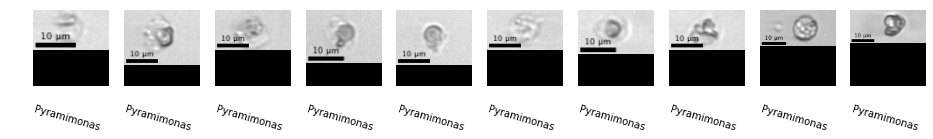

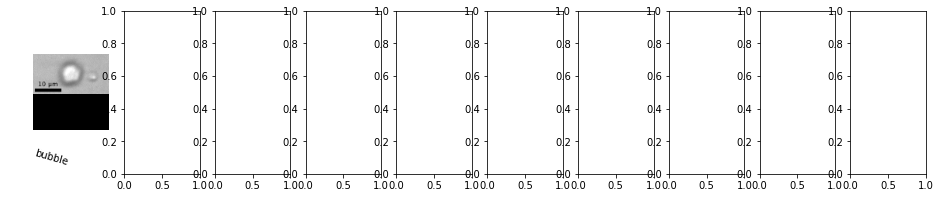

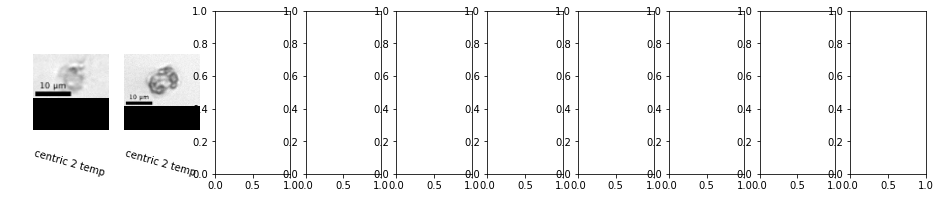

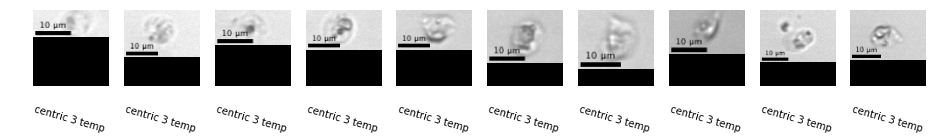

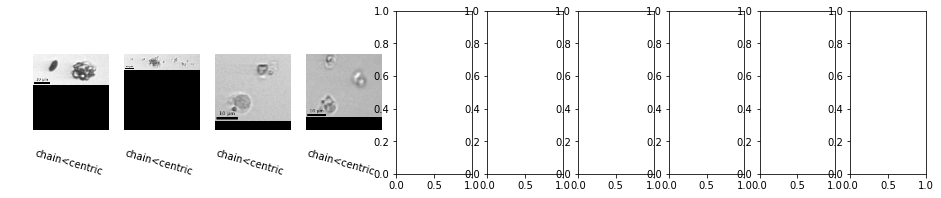

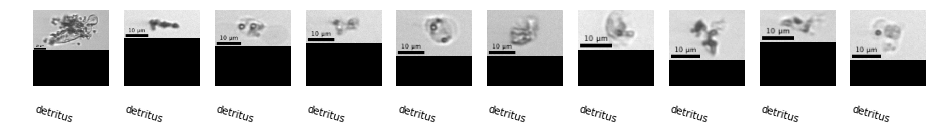

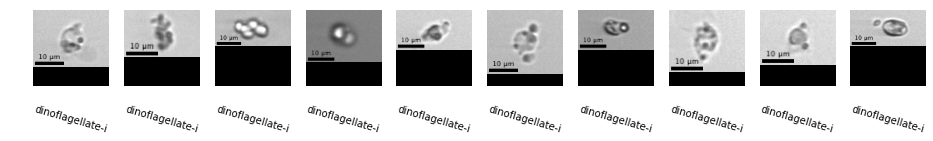

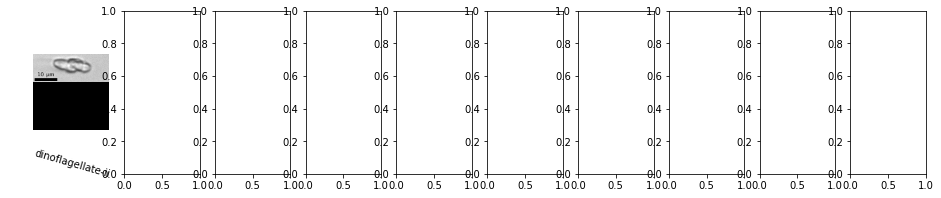

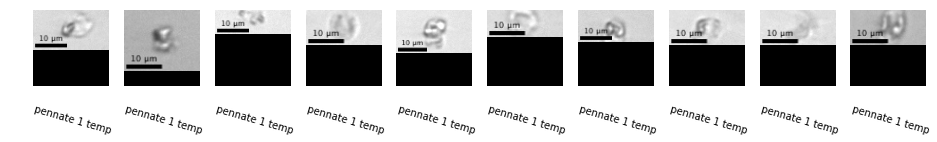

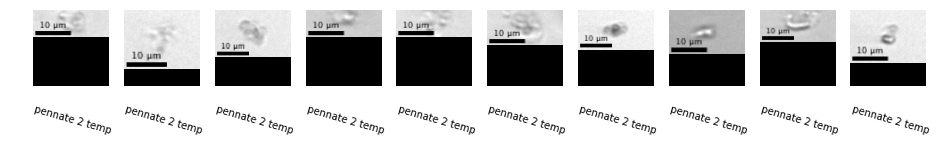

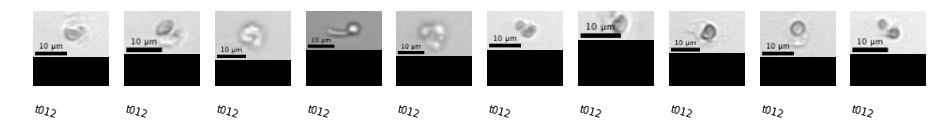

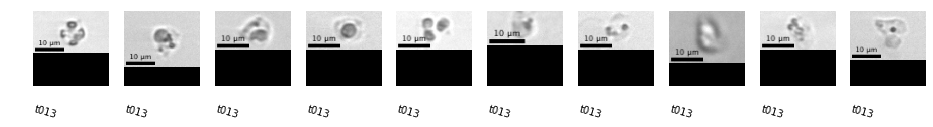

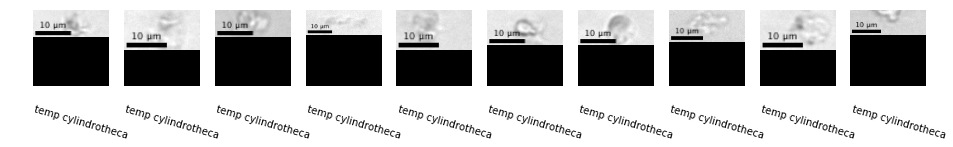

In [52]:
for i in range(len(class_id_dict)):
    if len(buckets[i]) > 0:
        fig, ax = plt.subplots(1, 10, figsize=(16, 3))  
        for j in range(0, 10):
            try: 
                desired_size = 150
                im = cv2.imread(imagery_fp+buckets[i][j]+'.png', cv2.IMREAD_GRAYSCALE)
                old_size = im.shape[:2] # old_size is in (height, width) format
                ratio = float(desired_size)/max(old_size)
                new_size = tuple([int(x*ratio) for x in old_size])
                # new_size should be in (width, height) format
                im = cv2.resize(im, (new_size[1], new_size[0]))
                delta_w = desired_size - new_size[1]
                delta_h = desired_size - new_size[0]
                top, bottom = delta_h//2, delta_h-(delta_h//2)
                left, right = delta_w//2, delta_w-(delta_w//2)
                new_im = cv2.copyMakeBorder(im, 0, delta_h, 0, delta_w, cv2.BORDER_CONSTANT,0)

                ax[j].imshow(new_im, cmap = 'gray')
                ax[j].axis('off')
                ax[j].text(0,200, id_class_dict[i],rotation=-16)
            except IndexError:
                continue
        plt.show()

Remove all of the class names from validated types that don't exist in the prediction class subset

In [53]:
live_preds_no_unknowns = live_preds[live_preds['validated_type'] != 'Unknowns']
live_preds_no_unknowns = live_preds_no_unknowns[live_preds_no_unknowns['validated_type'] != 'part<other']
live_preds_no_unknowns = live_preds_no_unknowns[live_preds_no_unknowns['validated_type'] != 'multiple<other']
live_preds_no_unknowns = live_preds_no_unknowns[live_preds_no_unknowns['validated_type'] != 'bead']
live_preds_no_unknowns = live_preds_no_unknowns[live_preds_no_unknowns['validated_type'] != 'badfocus<artefact']
live_preds_no_unknowns = live_preds_no_unknowns[live_preds_no_unknowns['validated_type'] != 't002']

len(live_preds_no_unknowns)

3435

Go from pandas dataframe to numpy array of labels and preds

In [54]:
all_preds = [class_id_dict[x] for x in live_preds_no_unknowns['object_annotation_category']]
all_labs = [class_id_dict[x] for x in live_preds_no_unknowns['validated_type']]

In [55]:
live_preds_no_unknowns['correct']  = 0

In [56]:
live_preds_no_unknowns.loc[live_preds_no_unknowns['object_annotation_category'] == live_preds_no_unknowns['validated_type'], 'correct'] = 1

Inspect the model confidence of the incorrect and correct predictions

(array([ 14.,  21.,  43.,  95.,  93.,  96.,  88., 104., 157., 699.]),
 array([0.27415505, 0.34673955, 0.41932404, 0.49190854, 0.56449303,
        0.63707753, 0.70966202, 0.78224652, 0.85483101, 0.92741551,
        1.        ]),
 <a list of 10 Patch objects>)

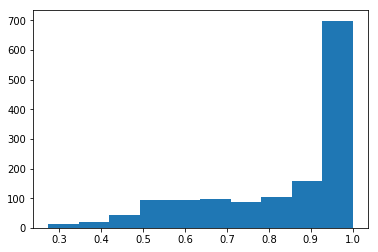

In [57]:
plt.hist(live_preds_no_unknowns[live_preds_no_unknowns['correct']==0]['object_score'])

(array([   5.,   12.,   18.,   34.,   33.,   40.,   54.,   55.,  120.,
        1654.]),
 array([0.28866512, 0.3597986 , 0.43093209, 0.50206558, 0.57319907,
        0.64433256, 0.71546605, 0.78659953, 0.85773302, 0.92886651,
        1.        ]),
 <a list of 10 Patch objects>)

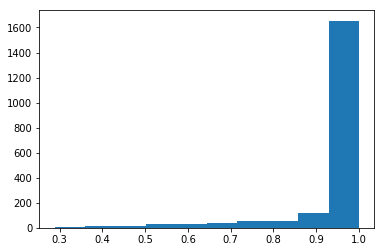

In [58]:
plt.hist(live_preds_no_unknowns[live_preds_no_unknowns['correct']==1]['object_score'])

In [59]:
np.sum(np.array(all_preds) == np.array(all_labs)) / len(all_labs)

0.5895196506550219

Calculate overall precision/recall and then precision/recall on a per class basis

In [60]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), average='weighted', labels=list(id_class_dict.keys()))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.7385561060808602, 0.5895196506550219, 0.6156108536672025, None)

In [61]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(all_labs), np.array(all_preds), 
                                average=None, labels=list(id_class_dict.keys()))

If any classes didn't get predicted or weren't in the data this fills in zeros for them so these eval metrics work

In [62]:
classes, counts = np.unique(all_preds, return_counts=True)
true_classes, true_counts = np.unique(all_labs, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if i >= len(classes):
        filled_counts.append(0)
        prev_class += 1
    elif classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if i >= len(true_classes):
        filled_true_counts.append(0)
        prev_class += 1
    elif true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

Now the evaluation metrics

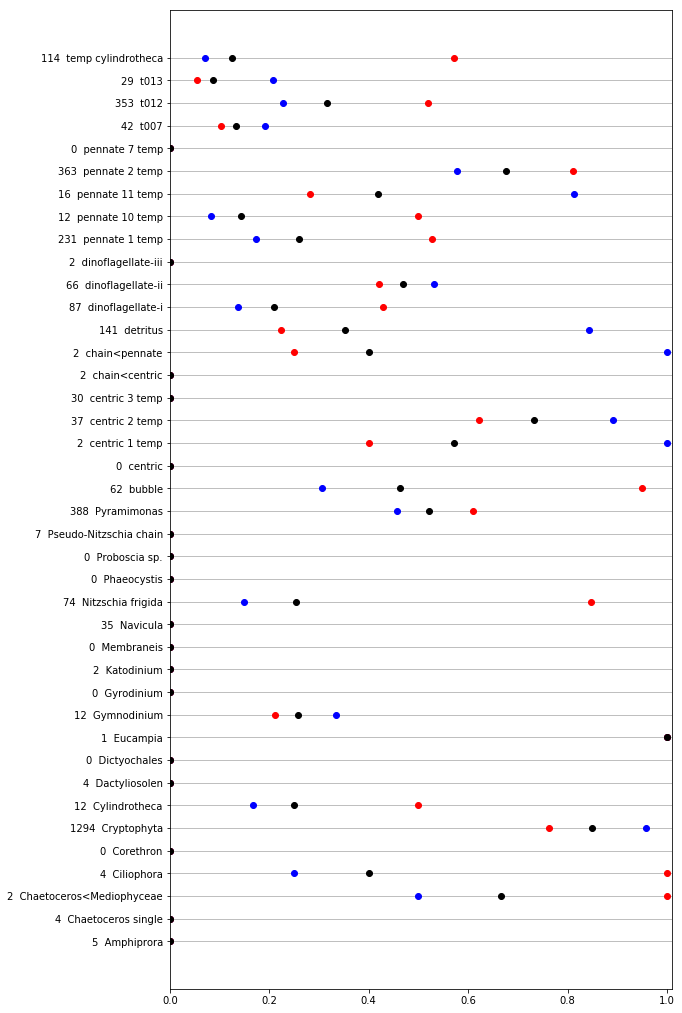

In [63]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix
len(class_id_dict), confusion_matrix(np.array(all_labs), np.array(all_preds)).shape

(40, (34, 34))

This adds a single sample to classes with no predictions just so they exist in the analysis

In [65]:
for i in list(set(range(0,len(class_id_dict))) - set(classes)):
    all_labs.append(i)
    all_preds.append(i)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


Text(0.5, 318.47499999999985, 'Predicted label')

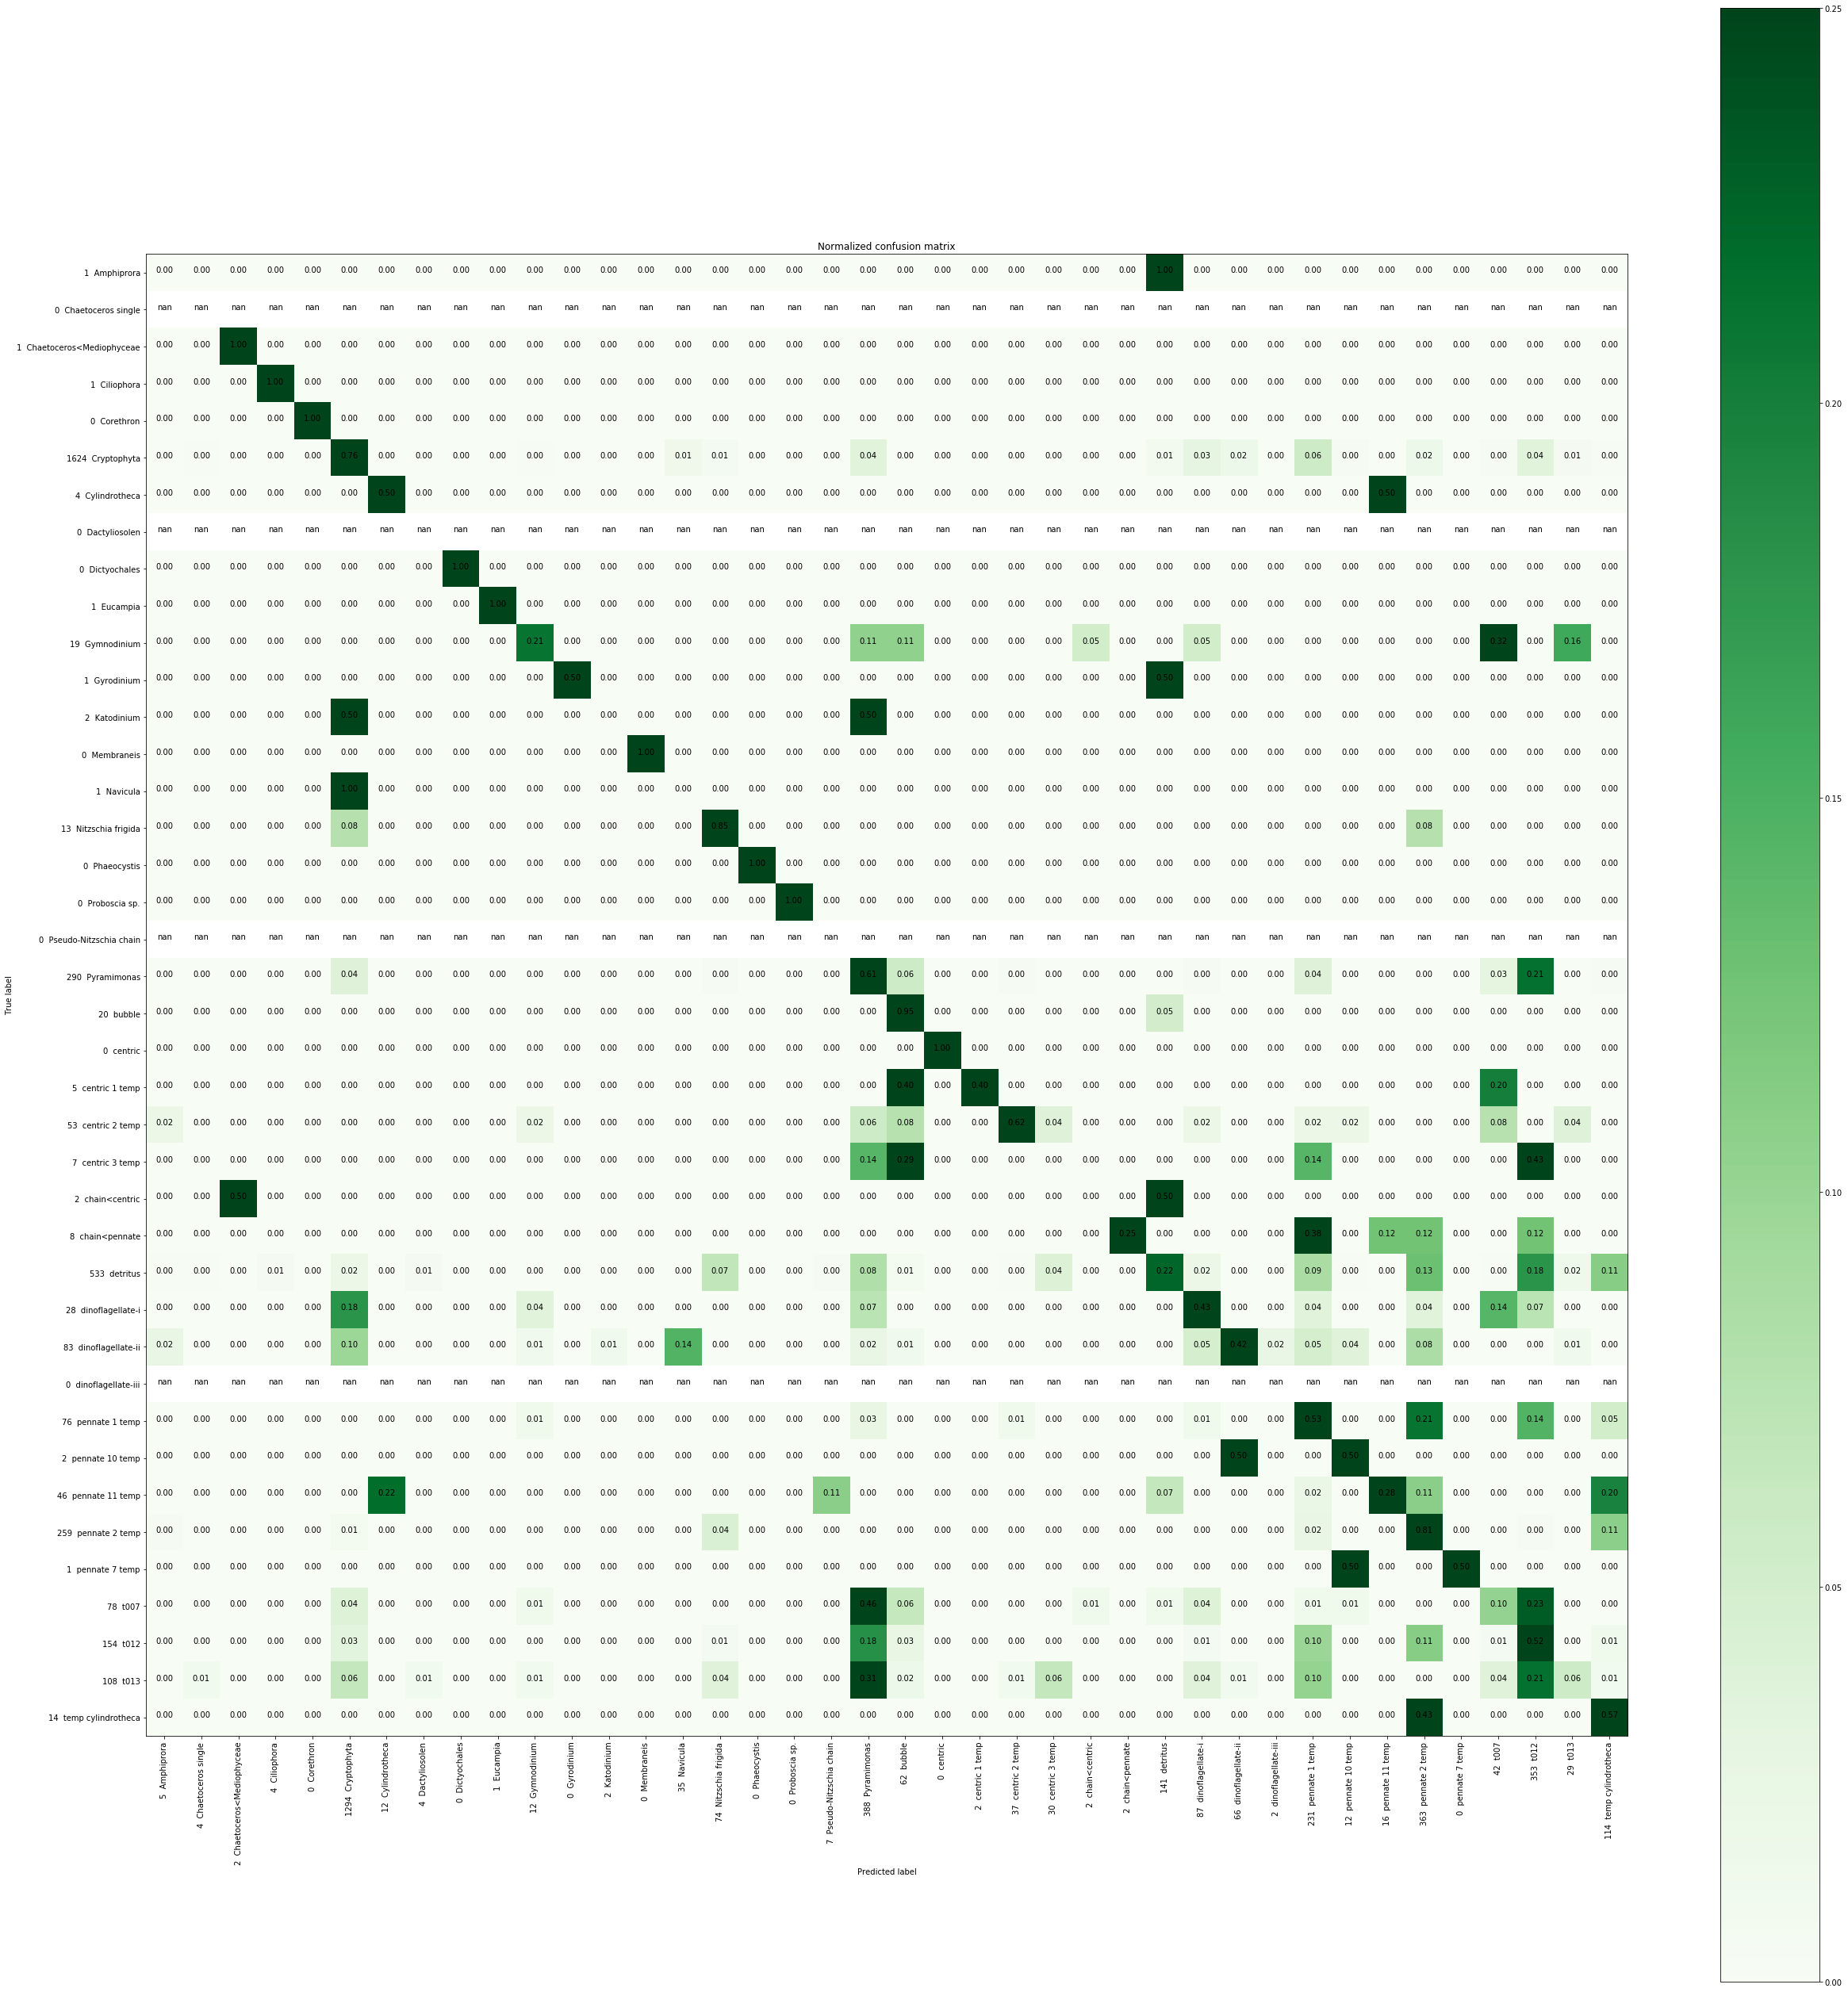

In [67]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(all_labs), np.array(all_preds))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

#print(cm)
plt.figure(figsize=(35,35)) 

plt.imshow(cm, cmap = 'Greens', vmax=0.25)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('../../conf_matrix_unmerged_visible_low_end_large_validated.png', dpi=300)

In [68]:
counts, classes

(array([   5,    4,    2,    4, 1294,   12,    4,    1,   12,    2,   35,
          74,    7,  388,   62,    2,   37,   30,    2,    2,  141,   87,
          66,    2,  231,   12,   16,  363,   42,  353,   29,  114]),
 array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 12, 14, 15, 18, 19, 20, 22, 23,
        24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39]))

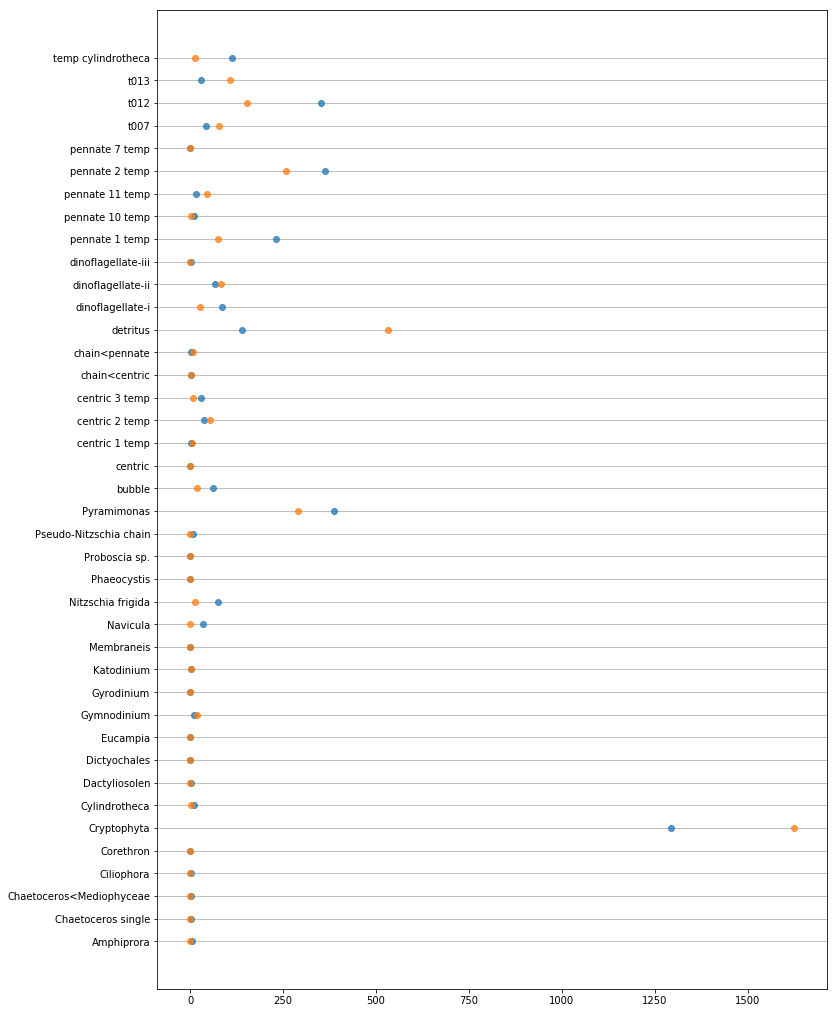

In [69]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(0,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Medium merged categories

In [70]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'bubble': 20,
 'centric': 21,
 'centric 1 temp': 22,
 'centric 2 temp': 23,
 'centric 3 temp': 24,
 'chain<centric': 25,
 'chain<pennate': 26,
 'detritus': 27,
 'dinoflagellate-i': 28,
 'dinoflagellate-ii': 29,
 'dinoflagellate-iii': 30,
 'pennate 1 temp': 31,
 'pennate 10 temp': 32,
 'pennate 11 temp': 33,
 'pennate 2 temp': 34,
 'pennate 7 temp': 35,
 't007': 36,
 't012': 37,
 't013': 38,
 'temp cylindrotheca': 39}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

['Amphiprora',
 'Chaetoceros single',
 'Chaetoceros<Mediophyceae',
 'Ciliophora',
 'Corethron',
 'Cryptophyta',
 'Cylindrotheca',
 'Dactyliosolen',
 'Dictyochales',
 'Eucampia',
 'Gymnodinium',
 'Gyrodinium',
 'Katodinium',
 'Membraneis',
 'Navicula',
 'Nitzschia frigida',
 'Phaeocystis',
 'Proboscia sp.',
 'Pseudo-Nitzschia chain',
 'Pyramimonas',
 'bubble',
 'centric',
 'centric 1 temp',
 'centric 2 temp',
 'centric 3 temp',
 'chain<centric',
 'chain<pennate',
 'detritus',
 'dinoflagellate-i',
 'dinoflagellate-ii',
 'dinoflagellate-iii',
 'pennate 1 temp',
 'pennate 10 temp',
 'pennate 11 temp',
 'pennate 2 temp',
 'pennate 7 temp',
 't007',
 't012',
 't013',
 'temp cylindrotheca']

In [71]:
# Diatoms: 

## Pennate Diatoms:
amphiprora = ['Amphiprora']                    
cylindrotheca = ['Cylindrotheca']                 
nitzschia_frigida = ['Nitzschia frigida']             
pseudo_nitzschia_chain = ['Pseudo-Nitzschia chain'] 

unidentified_single_pennate = [
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
]

## Centric Diatoms
chaetoceros_mediophyceae = ['Chaetoceros<Mediophyceae']
chaetoceros_single = ['Chaetoceros single']
corethron = ['Corethron']
eucampia = ['Eucampia']
dactyliosolen = ['Dactyliosolen']
proboscia = ['Proboscia sp.']
unidentified_single_centric = [
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

# Dinoflagellates: 
gyrodinium = ['Gyrodinium']
gymnodinium = ['Gymnodinium'] 
katodinium = ['Katodinium']
dinoflagellate_i = ['dinoflagellate-i']
dinoflagellate_ii = ['dinoflagellate-ii']
dinoflagellate_iii = ['dinoflagellate-iii']

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']

unidentified_flagellates = [ 
    't007',
    't012',
    't013',
]

other = [ 
    'bubble',
    'detritus',
]

In [72]:
all_classes = list(class_id_dict)

In [73]:
all_classes_sep = amphiprora+cylindrotheca+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia+dactyliosolen +proboscia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+pyramimonas +phaeocystis+dictyochales +ciliophora+unidentified_flagellates+other
len(all_classes), len(all_classes_sep)

(40, 40)

In [74]:
class_str = 'amphiprora+cylindrotheca+nitzschia_frigida+pseudo_nitzschia_chain+unidentified_single_pennate+chaetoceros_mediophyceae+chaetoceros_single+corethron+eucampia+dactyliosolen +proboscia +unidentified_single_centric+cryptophyta+gyrodinium+gymnodinium+katodinium+dinoflagellate_i+dinoflagellate_ii +dinoflagellate_iii+pyramimonas +phaeocystis+dictyochales +ciliophora +unidentified_flagellates+other'
class_str.replace('+', ',')

'amphiprora,cylindrotheca,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia,dactyliosolen ,proboscia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,unidentified_flagellates,other'

In [75]:
class_str.replace('+', "','")

"amphiprora','cylindrotheca','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia','dactyliosolen ','proboscia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','unidentified_flagellates','other"

### adding all the merged classes into the dataframe

In [76]:
classes = [amphiprora,cylindrotheca,nitzschia_frigida,pseudo_nitzschia_chain,unidentified_single_pennate,chaetoceros_mediophyceae,chaetoceros_single,corethron,eucampia,dactyliosolen ,proboscia ,unidentified_single_centric,cryptophyta,gyrodinium,gymnodinium,katodinium,dinoflagellate_i,dinoflagellate_ii ,dinoflagellate_iii,pyramimonas ,phaeocystis,dictyochales ,ciliophora ,unidentified_flagellates,other]

class_names = ['amphiprora','cylindrotheca','nitzschia_frigida','pseudo_nitzschia_chain','unidentified_single_pennate','chaetoceros_mediophyceae','chaetoceros_single','corethron','eucampia','dactyliosolen ','proboscia ','unidentified_single_centric','cryptophyta','gyrodinium','gymnodinium','katodinium','dinoflagellate_i','dinoflagellate_ii ','dinoflagellate_iii','pyramimonas ','phaeocystis','dictyochales ','ciliophora ','unidentified_flagellates','other']

In [77]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [78]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])

In [79]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'amphiprora',
 1: 'cylindrotheca',
 2: 'nitzschia_frigida',
 3: 'pseudo_nitzschia_chain',
 4: 'unidentified_single_pennate',
 5: 'chaetoceros_mediophyceae',
 6: 'chaetoceros_single',
 7: 'corethron',
 8: 'eucampia',
 9: 'dactyliosolen ',
 10: 'proboscia ',
 11: 'unidentified_single_centric',
 12: 'cryptophyta',
 13: 'gyrodinium',
 14: 'gymnodinium',
 15: 'katodinium',
 16: 'dinoflagellate_i',
 17: 'dinoflagellate_ii ',
 18: 'dinoflagellate_iii',
 19: 'pyramimonas ',
 20: 'phaeocystis',
 21: 'dictyochales ',
 22: 'ciliophora ',
 23: 'unidentified_flagellates',
 24: 'other'}

In [80]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

(3443, 3443)

In [81]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

(3443, 3443)

In [82]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

(0.7200670491873526, 0.6293929712460063, 0.6420113897332436, None)

In [83]:
np.sum(np.array(merged_labs_id) == np.array(merged_truth_id)) / len(merged_truth_id)

0.6293929712460063

In [84]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [85]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

In [86]:
len(class_id_dict), confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id)).shape

(25, (25, 25))

In [87]:
classes, counts = np.unique(merged_labs_id, return_counts=True)
true_classes, true_counts = np.unique(merged_truth_id, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

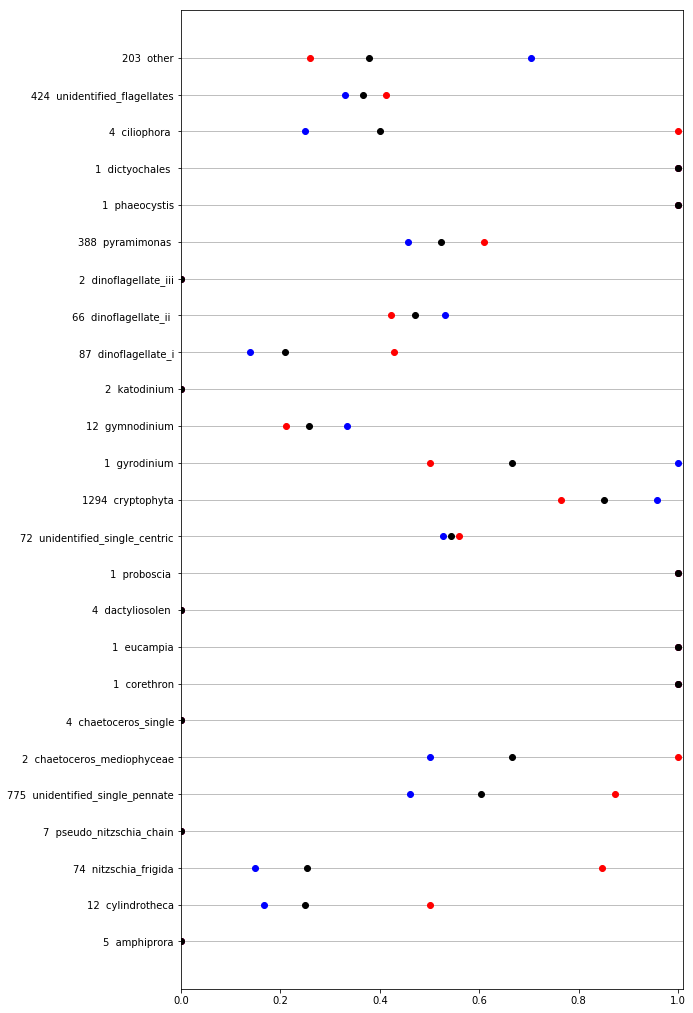

In [88]:
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Text(0.5, 30.14999999999995, 'Predicted label')

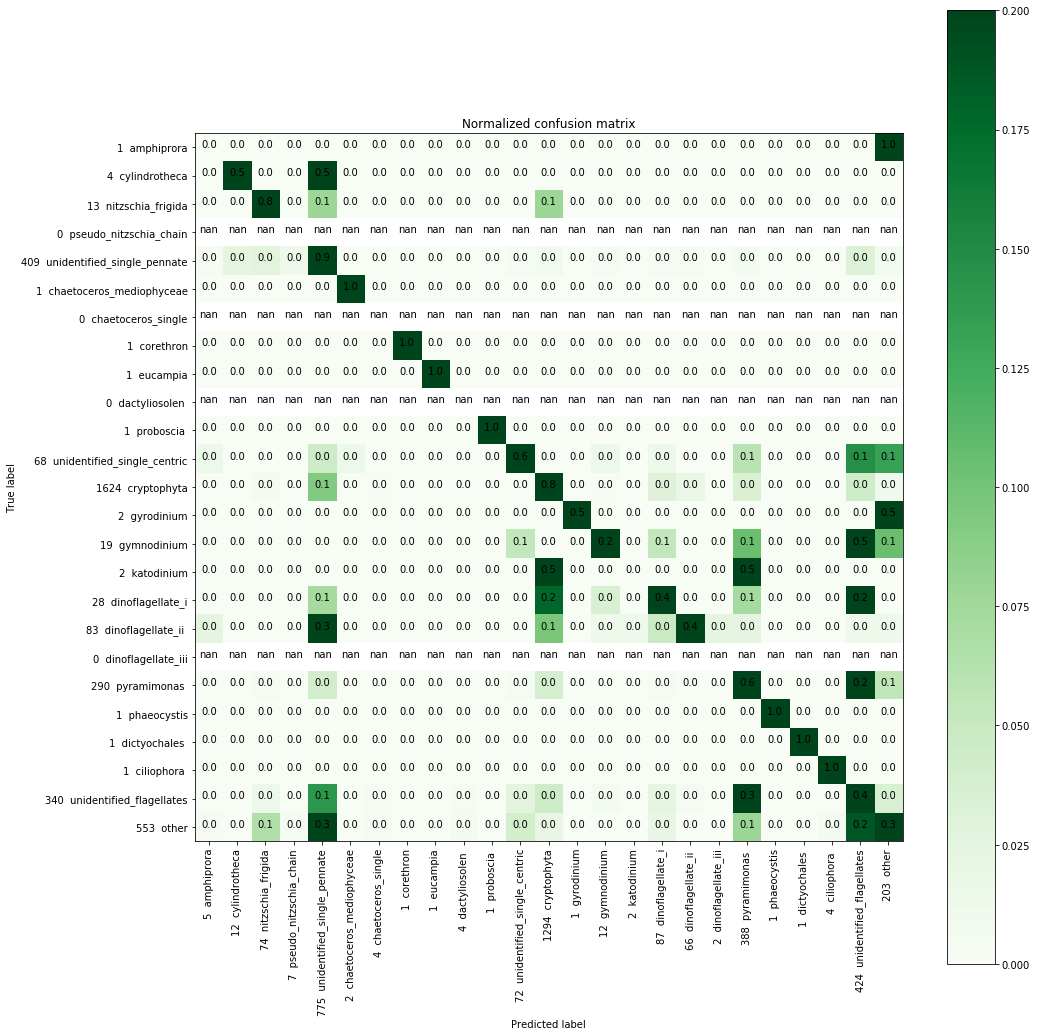

In [89]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_truth_id), np.array(merged_labs_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_medium_merged.png', dpi=300)

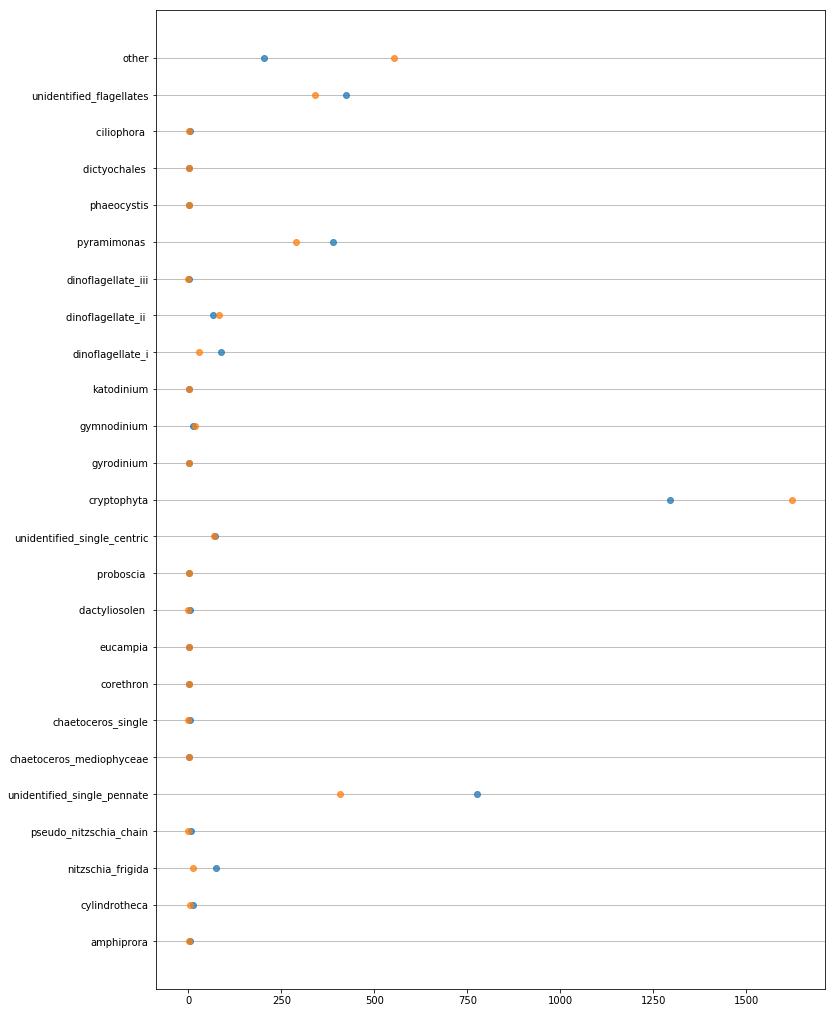

In [90]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Now moving to super merged categories

In [91]:
class_id_dict = {'Amphiprora': 0,
 'Chaetoceros single': 1,
 'Chaetoceros<Mediophyceae': 2,
 'Ciliophora': 3,
 'Corethron': 4,
 'Cryptophyta': 5,
 'Cylindrotheca': 6,
 'Dactyliosolen': 7,
 'Dictyochales': 8,
 'Eucampia': 9,
 'Gymnodinium': 10,
 'Gyrodinium': 11,
 'Katodinium': 12,
 'Membraneis': 13,
 'Navicula': 14,
 'Nitzschia frigida': 15,
 'Phaeocystis': 16,
 'Proboscia sp.': 17,
 'Pseudo-Nitzschia chain': 18,
 'Pyramimonas': 19,
 'bubble': 20,
 'centric': 21,
 'centric 1 temp': 22,
 'centric 2 temp': 23,
 'centric 3 temp': 24,
 'chain<centric': 25,
 'chain<pennate': 26,
 'detritus': 27,
 'dinoflagellate-i': 28,
 'dinoflagellate-ii': 29,
 'dinoflagellate-iii': 30,
 'pennate 1 temp': 31,
 'pennate 10 temp': 32,
 'pennate 11 temp': 33,
 'pennate 2 temp': 34,
 'pennate 7 temp': 35,
 't007': 36,
 't012': 37,
 't013': 38,
 'temp cylindrotheca': 39}
id_class_dict = dict((v,k) for k,v in class_id_dict.items())

In [92]:
# Diatoms: 


## Pennate Diatoms:
pennates = [
    'Amphiprora',                    
    'Cylindrotheca'  ,             
    'Nitzschia frigida'  ,        
    'Pseudo-Nitzschia chain',
    'Membraneis',
    'Navicula',
    'temp cylindrotheca',
    'pennate 1 temp',
    'pennate 2 temp',
    'pennate 7 temp',
    'pennate 10 temp',
    'pennate 11 temp',
    'chain<pennate',
]

## Centric Diatoms
centrics = [
    'Chaetoceros<Mediophyceae',
    'Chaetoceros single',
    'Corethron',
    'Eucampia',
    'Dactyliosolen',
    'Proboscia sp.',
    'centric 1 temp',
    'centric 2 temp',
    'centric 3 temp',
    'centric',
    'chain<centric'
]

# Cryptophytes: 
cryptophyta = ['Cryptophyta']

dinoflagellates = [
    'Gyrodinium',
    'Gymnodinium',
    'Katodinium',
    'dinoflagellate-i',
    'dinoflagellate-ii',
    'dinoflagellate-iii',
]

# Prasinophytes/Chlorophytes:
pyramimonas = ['Pyramimonas']

# Haptophytes/Prymnesiophyte:
phaeocystis = ['Phaeocystis']

# Silicoflagellates:
dictyochales = ['Dictyochales']

# Microzooplankton: 
ciliophora = ['Ciliophora']

unidentified_flagellates = [ 
    't007',
    't012',
    't013',
]

other = [ 
    'bubble',
    'detritus',
]

In [93]:
all_classes = list(class_id_dict)

In [94]:
all_classes_sep = pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+unidentified_flagellates+other
len(all_classes), len(all_classes_sep)

(40, 40)

In [95]:
class_str = 'pennates+centrics+cryptophyta+dinoflagellates+pyramimonas+phaeocystis+dictyochales+ciliophora+unidentified_flagellates+other'
class_str.replace('+', ',')

'pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,unidentified_flagellates,other'

In [96]:
class_str.replace('+', "','")

"pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','unidentified_flagellates','other"

### adding all the merged classes into the dataframe

In [97]:
classes = [pennates,centrics,cryptophyta,dinoflagellates,pyramimonas,phaeocystis,dictyochales,ciliophora,unidentified_flagellates,other]

class_names = ['pennates','centrics','cryptophyta','dinoflagellates','pyramimonas','phaeocystis','dictyochales','ciliophora','unidentified_flagellates','other']

In [98]:
merged_labs_truth = []
for lab in all_labs:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs_truth.append(class_names[i])

In [99]:
merged_labs = []
for lab in all_preds:
    for i in range(len(classes)):
        if id_class_dict[lab] in classes[i]: 
            merged_labs.append(class_names[i])

In [100]:
class_id_list = [[x, i] for i, x in enumerate(class_names)]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'pennates',
 1: 'centrics',
 2: 'cryptophyta',
 3: 'dinoflagellates',
 4: 'pyramimonas',
 5: 'phaeocystis',
 6: 'dictyochales',
 7: 'ciliophora',
 8: 'unidentified_flagellates',
 9: 'other'}

In [101]:
merged_labs_id = [class_id_dict[x] for x in merged_labs]
len(merged_labs), len(merged_labs_id)

(3443, 3443)

In [102]:
merged_truth_id = [class_id_dict[x] for x in merged_labs_truth]
len(merged_labs_truth), len(merged_truth_id)

(3443, 3443)

In [103]:
np.sum(np.array(merged_labs_id) == np.array(merged_truth_id)) / len(merged_truth_id)

0.6413011908219576

In [104]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), average='weighted', labels=list(id_class_dict.keys()))

(0.7184228140617833, 0.6413011908219576, 0.6461593421517162, None)

In [105]:
from sklearn.metrics import precision_recall_fscore_support

"""
returns:

precision float (if average is not None) or array of float, shape = [n_unique_labels]
recall float (if average is not None) or array of float, , shape = [n_unique_labels]
fbeta_score float (if average is not None) or array of float, shape = [n_unique_labels]
support None (if average is not None) or array of int, shape = [n_unique_labels]
    The number of occurrences of each label in y_true.
"""

precision, recall, fscore, supports = precision_recall_fscore_support(np.array(merged_truth_id), np.array(merged_labs_id), 
                                average=None, labels=list(id_class_dict.keys()))

In [106]:
names = [id_class_dict[x] for x in list(id_class_dict.keys())]

In [107]:
len(class_id_dict), confusion_matrix(np.array(merged_labs_id), np.array(merged_truth_id)).shape

(10, (10, 10))

In [108]:
classes, counts = np.unique(merged_labs_id, return_counts=True)
true_classes, true_counts = np.unique(merged_truth_id, return_counts=True)

filled_counts = []
prev_class = -1
i = 0
while len(filled_counts) < len(id_class_dict):
    if classes[i] != 1+prev_class:
        filled_counts.append(0)
        prev_class += 1
    else:
        filled_counts.append(counts[i])
        i += 1
        prev_class += 1
    
filled_true_counts = []
prev_class = -1
i = 0
while len(filled_true_counts) < len(id_class_dict):
    if true_classes[i] != 1+prev_class:
        filled_true_counts.append(0)
        prev_class += 1
    else:
        filled_true_counts.append(true_counts[i])
        i += 1
        prev_class += 1

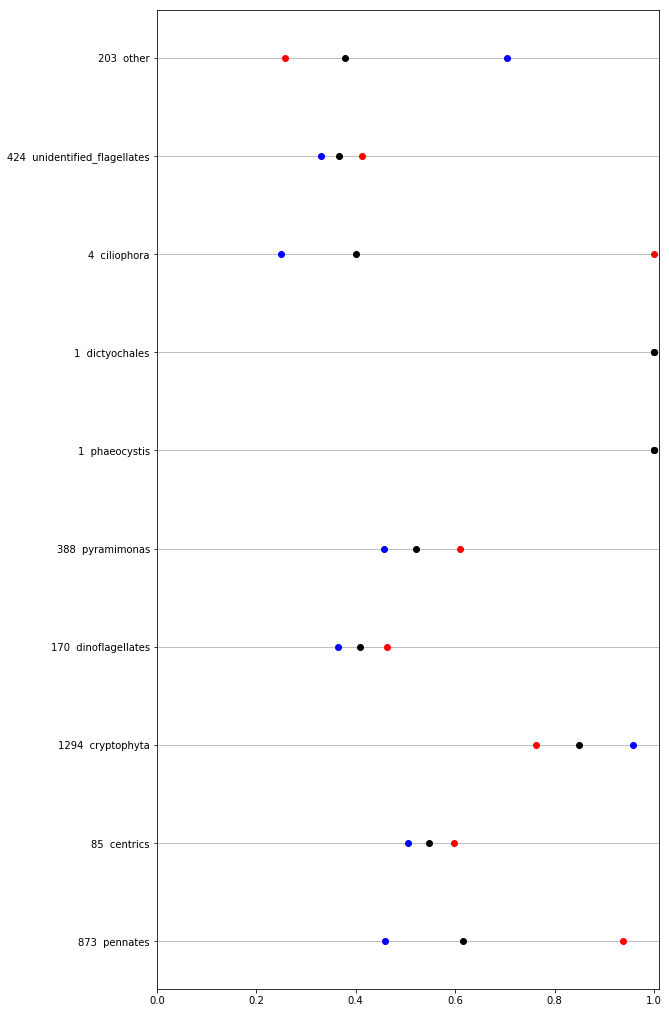

In [109]:
nc = [str(n) + '  ' + m for m,n in zip(names,filled_counts)]
n_tc = [str(n) + '  ' + m for m,n in zip(names,filled_true_counts)]

fig, ax = plt.subplots(figsize=(9, 18))
ax.scatter(precision, names, color='blue')
ax.scatter(recall, names, color='red')
ax.scatter(fscore, names, color='black')
ax.set_yticks(range(0,len(names)))
ax.set_yticklabels(nc)
ax.set_xlim(0,1.01)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('merged_class_acc.png', dpi=300)
plt.show()

Text(0.5, 54.27499999999995, 'Predicted label')

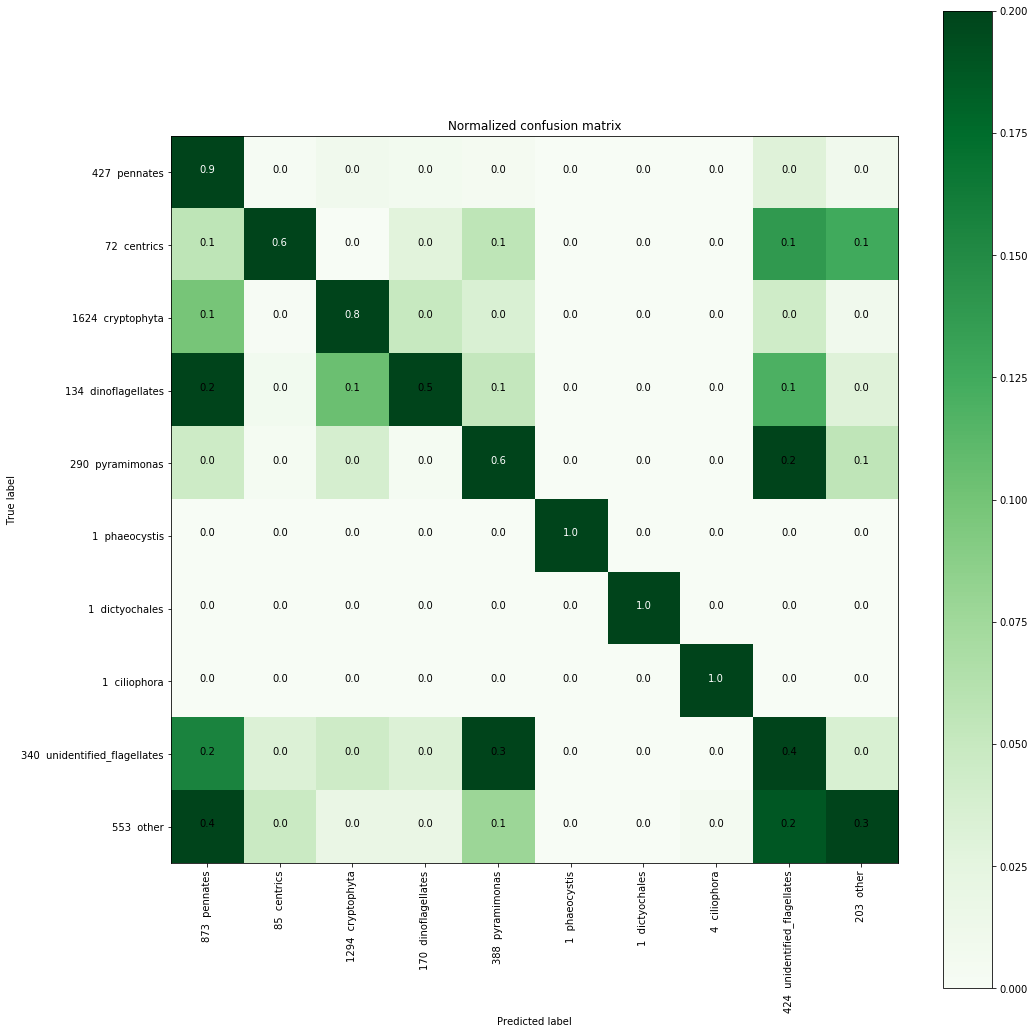

In [110]:
from sklearn.metrics import confusion_matrix
import itertools

num_classes = len(class_id_dict)

cm = confusion_matrix(np.array(merged_truth_id), np.array(merged_labs_id))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# print(cm)
plt.figure(figsize=(15,15)) 

plt.imshow(cm, cmap = 'Greens',vmax=0.2)
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, nc, rotation=90)
plt.yticks(tick_marks, n_tc)

fmt = '.1f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.axis('off')
#plt.grid(b=None, which='major', axis='both')

#plt.savefig('conf_matrix_medium_merged.png', dpi=300)

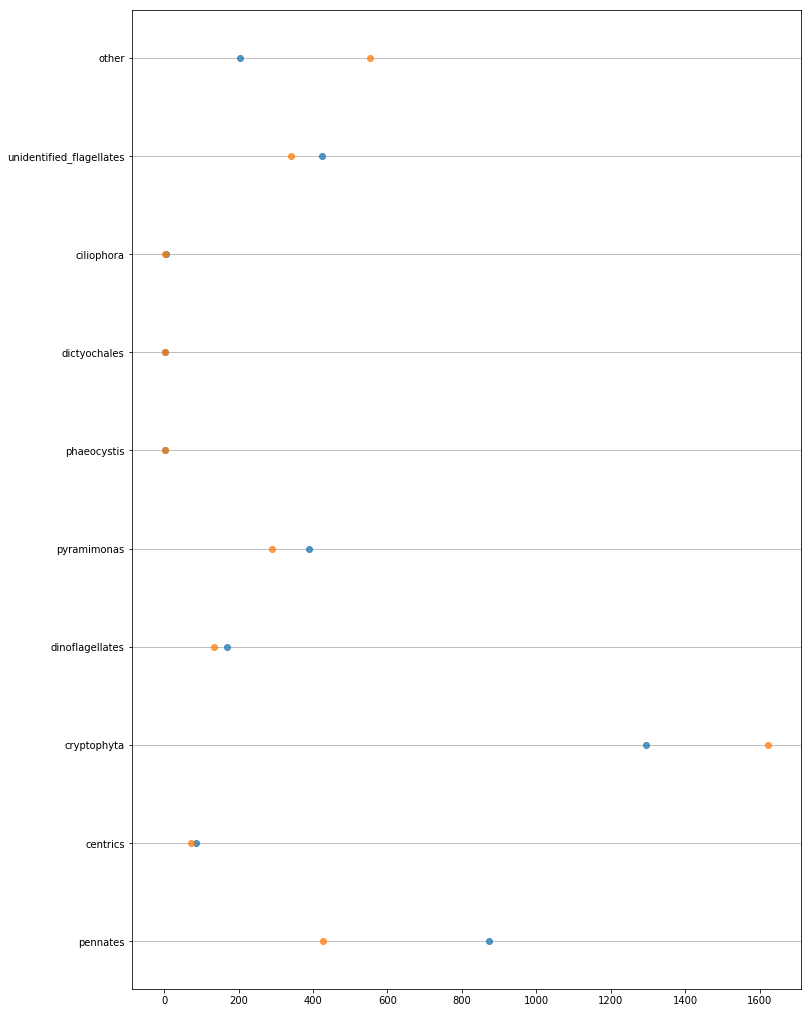

In [111]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(filled_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.scatter(filled_true_counts, range(0,len(id_class_dict)), alpha=0.75)
ax.set_yticks(range(0,len(id_class_dict)))
ax.set_yticklabels([id_class_dict[i] for i in range(len(id_class_dict))])
#ax.set_xlim(0,6000)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()